<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF - 477  Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Andrea Freire - Francisco Sáez </H3>
<hr style="height:2px;border:none"/>


# 3. Autoencoders en Fashion MNIST

Si bien las redes neuronales han tenido desempeños sorprendentes en muchas áreas donde antes solo un ser humano podía alcanzar buenos desempeños, uno de sus desventajas suele serla alta dimensionalidad de los espacios de hipótesis. En la práctica, esto implica que para aprender una tarea predictiva con alguna capacidad de generalización, se requieren grandes bases de datos etiquetadas. Esto implica un problema, considerando que al momento de buscar la base de datos, no se tiene a priori una manera de automatizar esta etiquetación. Esta necesidad de gran cantidad de trabajo de clasificación realizado por humanos, ha engendrado soluciones ingeniosas, como la aproximación de _Facebook_ hace algunos años de pedirle a los mismos usuarios que etiquetaran a las personas en sus fotos, o la solución de _Amazon_, _Mechanical Turk_, donde cualquier usuario puede realizar tareas repetitivas de clasificación a cambio de dinero real, o por otro lado cualquier persona puede comprar la etiquetación de una base de datos la cual realizan varias personas en cualquier parte del mundo. 

Otra aproximación, quizás aún más ingeniosa, para solucionar el problema de las etiquetas, es utilizar las bases de datos sin preocuparse de sus etiquetas. Esta aproximación de aprendizaje no supervisado tiene su representante en redes neuronales en los _Autoencoders_, redes que utilizan el mismo input como target y buscan representaciones de menor dimensionalidad al interior de la red. Estas redes han permitido el uso de cantidades masivas de datos para aprender de ellos sin necesidad de tener etiquetas. Durante esta pregunta veremos algunos de los aspectos y posibilidades básicas que nos presentan los _autoencoders_, utilizando una base de datos de imágenes de articulos de vestimenta, el Fashion MNIST. 

## 3.a) Carga de datos y visualizaciones
Cargue los datos. Puede usar las funciones de `keras.datasets` como muestra el código o descargarlo manualmente. 

Luego, visualice algunas imagenes de cada una de las catégorias junto con sus nombres (investigue un poco para encontrar la codificación de `y`). Note que las imagenes deben representarse en blanco y negro, puede usar `cmap='Greys'`. ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación? ¿Qué tan bien cree que se desempeñaría un humano en esta tarea?

In [1]:
from keras.datasets import fashion_mnist
(x_tr,y_tr),(x_val,y_val) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


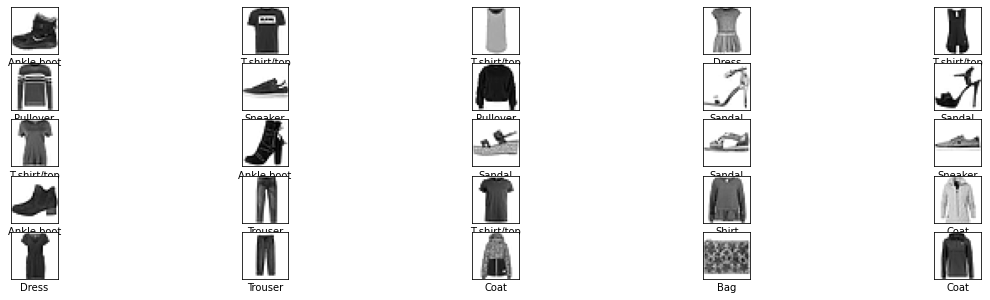

In [2]:
import matplotlib.pyplot as plt
import numpy as np

labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
plt.figure(figsize=(20,5))

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xlabel(labeldict[y_tr[i]])
  plt.imshow(x_tr[i],cmap=plt.cm.binary)
  plt.xticks([])
  plt.yticks([])
plt.show()

Cada uno de los ejemplos de entrenamiento y test es asignado a una de las siguientes etiquetas:

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot

Los que crearian errores entre si al momento de clasificar por su similaridad serian las clases sandal con sneaker, sandal con ankle boot, pullover con shirt y coat, t-shirt con dress. 

## 3.b Posibilidades de preprocesamiento y pequeños análisis. 

Las primeras redes que entrenaremos utilizarán arquitecturas _fully connected_, por lo cual también es necesario transformar nuestras imagenes 2-dimensionales a vectores, como muestra el ejemplo de código.

**Preguntas:**

i) ¿Cuáles son los rangos de valores de `x`? ¿Por qué?

ii) ¿Las distintas clases de ejemplos están balanceadas?

iii) ¿Considera necesario realizar un preprocesamiento? Escale los valores de `x` al intervalo $[0,1]$, y guarde el conjunto de datos original de igual manera que el escalado. ¿Se pierde información al realizar este preprocesamiento? 


i) Los rangos de los valores que pueden tomar los pixeles es de 0 a 255 porque estan en formato de escala de grises.

ii)Si estan balanceadas las 10 clases para los datos de entrenamiento como para los datos de validacion.

In [3]:
(unique, counts) = np.unique(y_tr, return_counts=True)

frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 6000]
 [   1 6000]
 [   2 6000]
 [   3 6000]
 [   4 6000]
 [   5 6000]
 [   6 6000]
 [   7 6000]
 [   8 6000]
 [   9 6000]]


In [4]:
(unique, counts) = np.unique(y_val, return_counts=True)

frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]


iii)si es necesario, no se pierde informacion en el preprocesamiento porque no es una reduccion de dimension sino que para representar los 255 valores de gris se los representa entre 0 y 1. 

In [5]:
x_tr_vector = x_tr.reshape(-1,28*28)
x_val_vector = x_val.reshape(-1,28*28)

In [6]:
x_train_vector_scaled = x_tr_vector / 255
x_val_vector_scaled = x_val_vector / 255

## 3.c) Primer Autoencoder

Entrenaremos un primer autoencoder de una capa oculta, usando arquitectura densa. Para esto, utilize como guía los códigos presentados abajo. 

Utilice en primera instancia su conjunto de datos escalados. Considerando el intervalo de los datos escalados.

Entrene esta primera red utilizando pérdida _binary cross entropy_. Compare luego las imagenes originales con las imagenes reconstruidas, como muestra el código. **Grafique** como varia la pérdida a lo largo del entrenamiento y visualice algunas imagenes reconstruidas. 

**Preguntas:**

i) ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta? 

ii) ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion?

**Respuesta**
i)Como las salidas son entre cero y uno se sugiere que se use la sigmoid en vez de la relu, pero para este caso se usara la relu. En el resto de arquitecturas se usa la funcion de activacion sigmoid en la ultima capa.
ii) El desempeño es decente pero no llega a una clasificacion casi perfecta, mas parece que solo ve las siluetas. Aqui hay algo diferente cuando se usa relu que cuando se usa sigmoid en la capa final aca esta muy oscuro en cambio con la sigmoide esta muy claro los valores.

In [8]:
from keras.layers import Dense
from keras.optimizers import SGD,Adam
from keras.models import Sequential

autoencoder = Sequential()

autoencoder.add(Dense(32,activation='relu')) # encoder
 
autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
hist = autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))


Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3604 - val_loss: 0.2959
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2924 - val_loss: 0.2923
Epoch 3/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2905 - val_loss: 0.2921
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2888 - val_loss: 0.2913
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2886 - val_loss: 0.2906
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2890 - val_loss: 0.2906
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2882 - val_loss: 0.2908
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2881 - val_loss: 0.2905
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2889 - val_loss: 0.2911
Epoch 10/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.288

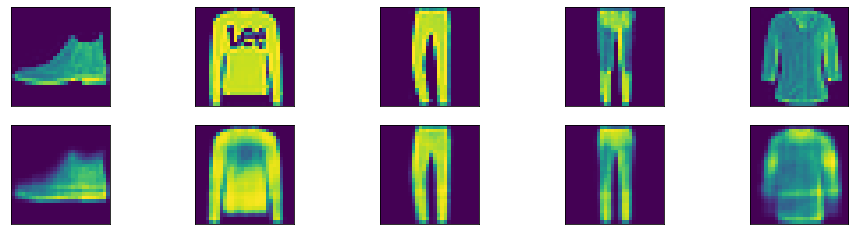

In [9]:
#con Sigmoide y Adam
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

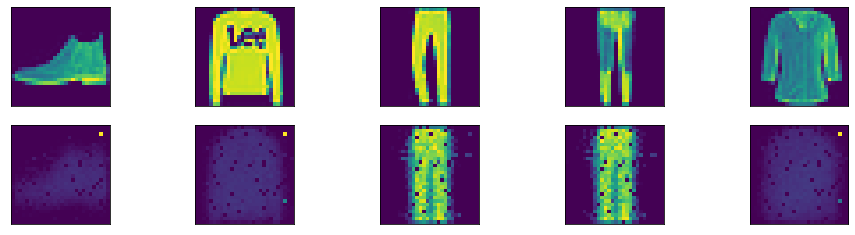

In [ ]:
#con Relu no ejecutar
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

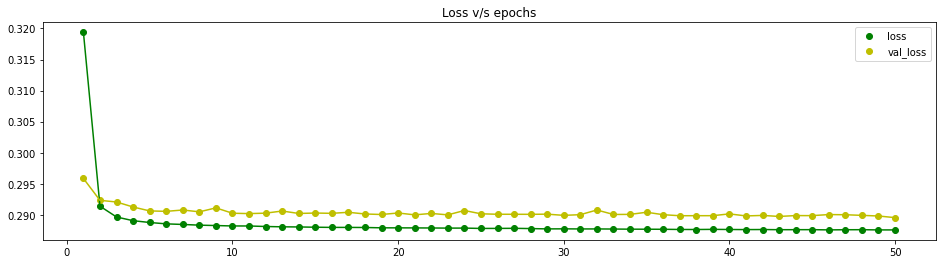

In [10]:
import matplotlib.pyplot as plt
hist.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist.history['loss']
hist.history['val_loss']
r = range(1,51,1)
plt.title('Loss v/s epochs')
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.plot(r, hist.history['loss'], 'go', label='loss')
plt.plot(r, hist.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist.history['loss'], 'g')
plt.plot(r, hist.history['val_loss'], 'y')
plt.legend()
plt.show()

## 3.d) Dimensionalidad

Una forma de interpretar lo que realiza el autoencoder, es considerar que si el autoencoder hace bien su tarea, la información necesaria para reconstruir la imagen original se encuentra en la capa oculta, la cual tiene menor dimensionalidad que la imagen original. Uno puede considerar por lo tanto que la capa de _encoding_ esta comprimiendo la información contenida en la imagen, mientras la capa de _decoding_ hace el proceso contrario, descomprimiendola a su estado original lo mejor posible. 

Explore como cambia el desempeño de la red en cuestión frente a cambios en la dimensión de la capa oculta. Pruebe a lo menos 5 niveles de compresión distintos, incluyendo uno donde la capa oculta tenga $50\%$ de ratio de compresión y otro donde la capa oculta tenga tan solo 2 neuronas. ¿Qué observa?

In [11]:
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential

autoencoder = Sequential()

autoencoder.add(Dense(588,activation='relu')) # encoder
 
autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
hist1 = autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))


Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3055 - val_loss: 0.2628
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2587 - val_loss: 0.2570
Epoch 3/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2541 - val_loss: 0.2556
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2526 - val_loss: 0.2543
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2518 - val_loss: 0.2536
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2508 - val_loss: 0.2535
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2516 - val_loss: 0.2530
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2509 - val_loss: 0.2529
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2506 - val_loss: 0.2527
Epoch 10/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.249

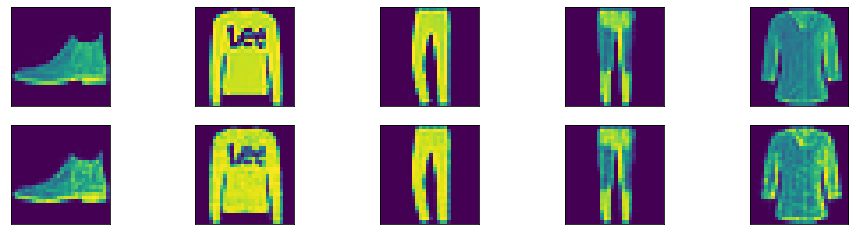

In [12]:
#con Adam y sigmoide
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

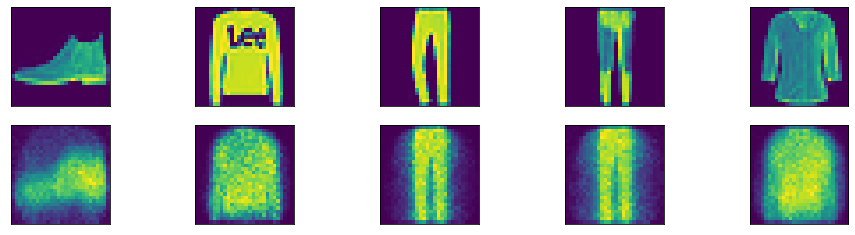

In [ ]:
#con relu no ejecutar
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

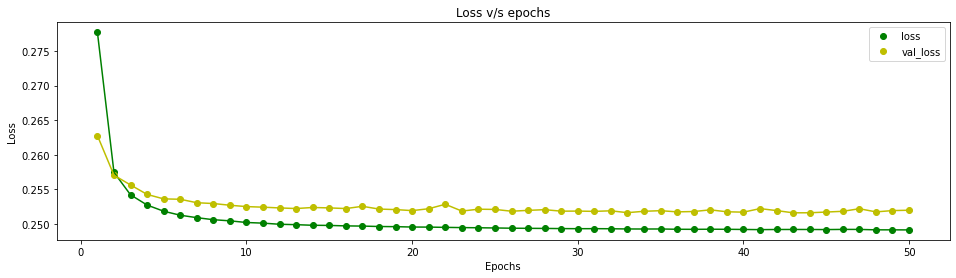

In [13]:
import matplotlib.pyplot as plt
hist1.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist1.history['loss']
hist1.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist1.history['loss'], 'go', label='loss')
plt.plot(r, hist1.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist1.history['loss'], 'g')
plt.plot(r, hist1.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:

autoencoder1 = Sequential()

autoencoder1.add(Dense(392,activation='relu')) # encoder
 
autoencoder1.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder1.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
hist2 = autoencoder1.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))


Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3095 - val_loss: 0.2645
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2606 - val_loss: 0.2606
Epoch 3/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2563 - val_loss: 0.2579
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2553 - val_loss: 0.2572
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2549 - val_loss: 0.2564
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2544 - val_loss: 0.2561
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2539 - val_loss: 0.2563
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2533 - val_loss: 0.2558
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2528 - val_loss: 0.2558
Epoch 10/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.253

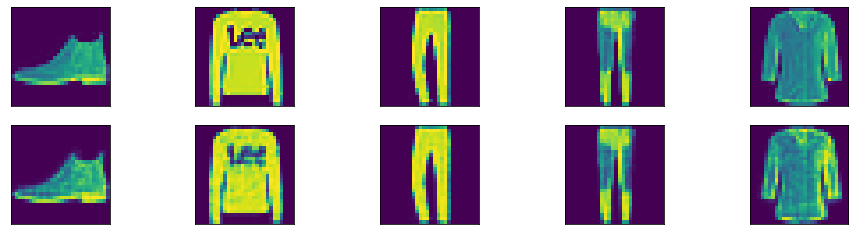

In [15]:
#con Adam y sigmoid
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder1.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

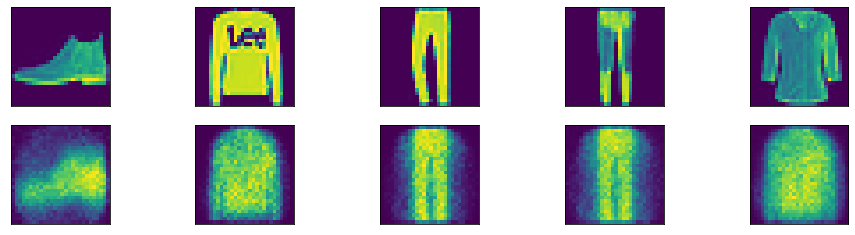

In [ ]:
#con relu y SGD no ejecutar
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder1.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

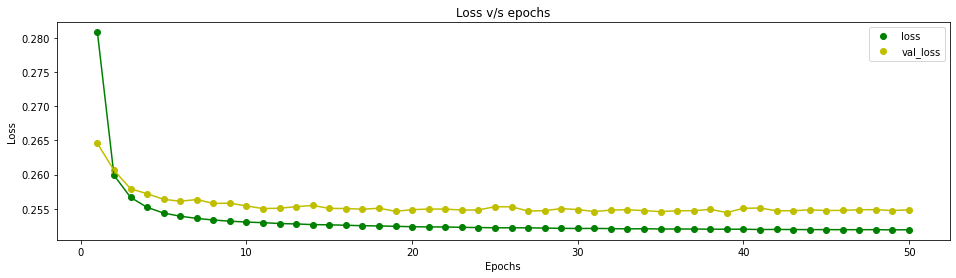

In [16]:
import matplotlib.pyplot as plt
hist2.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist2.history['loss']
hist2.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist2.history['loss'], 'go', label='loss')
plt.plot(r, hist2.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist2.history['loss'], 'g')
plt.plot(r, hist2.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:

autoencoder2 = Sequential()

autoencoder2.add(Dense(196,activation='relu')) # encoder
 
autoencoder2.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder2.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
hist3 = autoencoder2.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))


Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3194 - val_loss: 0.2706
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2667 - val_loss: 0.2655
Epoch 3/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2629 - val_loss: 0.2639
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2612 - val_loss: 0.2630
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2606 - val_loss: 0.2630
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2599 - val_loss: 0.2626
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2602 - val_loss: 0.2628
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2596 - val_loss: 0.2624
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2594 - val_loss: 0.2621
Epoch 10/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.259

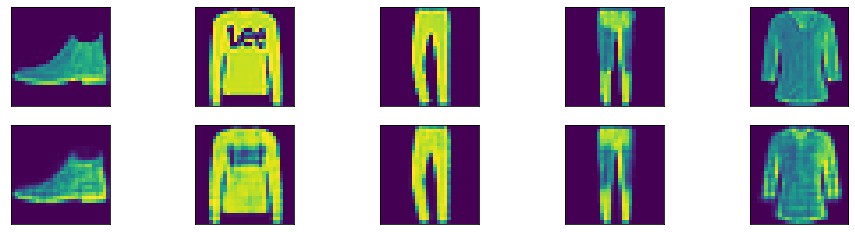

In [18]:
#con Adam y sigmoid
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder2.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

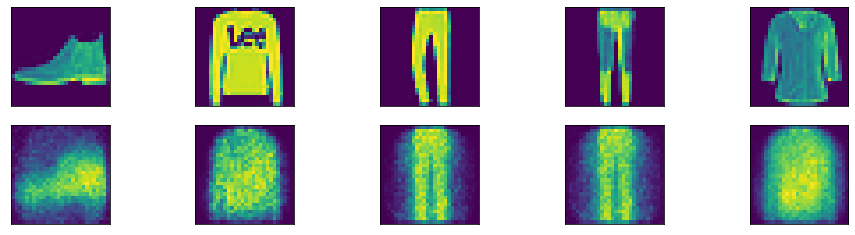

In [ ]:
#con relu y SGD no ejecutar
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder2.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

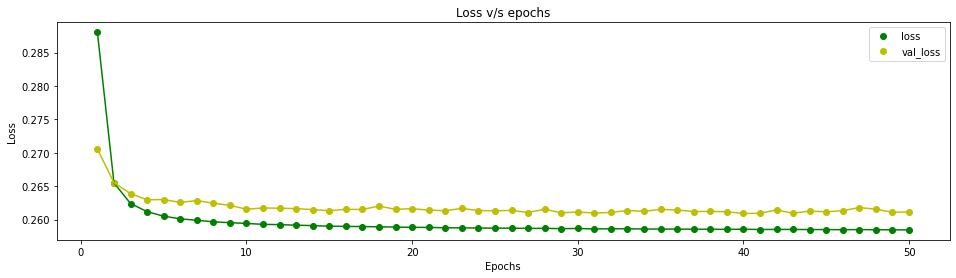

In [19]:
import matplotlib.pyplot as plt
hist3.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist3.history['loss']
hist3.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist3.history['loss'], 'go', label='loss')
plt.plot(r, hist3.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist3.history['loss'], 'g')
plt.plot(r, hist3.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:

autoencoder3 = Sequential()

autoencoder3.add(Dense(98,activation='relu')) # encoder
 
autoencoder3.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder3.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
hist4 = autoencoder3.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))

Epoch 1/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3330 - val_loss: 0.2778
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2742 - val_loss: 0.2733
Epoch 3/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2701 - val_loss: 0.2718
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2687 - val_loss: 0.2714
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2692 - val_loss: 0.2713
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2682 - val_loss: 0.2705
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2674 - val_loss: 0.2706
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2680 - val_loss: 0.2699
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2671 - val_loss: 0.2700
Epoch 10/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.268

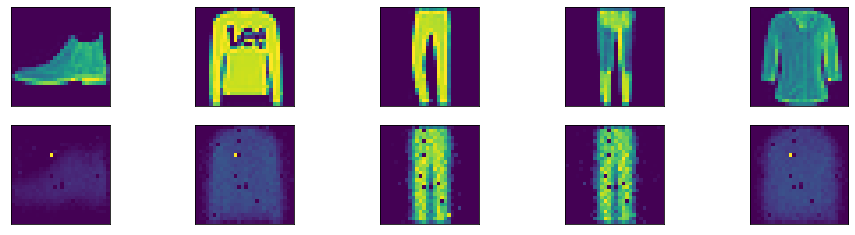

In [ ]:
#Con relu y SGD no ejecutar
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder3.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

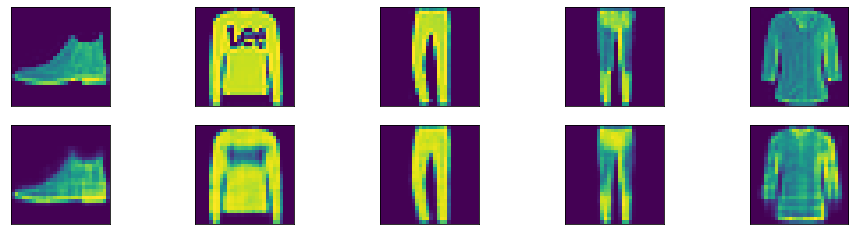

In [21]:
#con sigmoid y adam
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder3.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

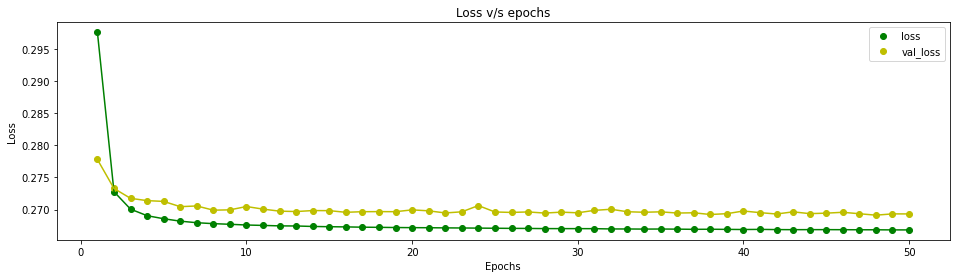

In [22]:
import matplotlib.pyplot as plt
hist4.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist4.history['loss']
hist4.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist4.history['loss'], 'go', label='loss')
plt.plot(r, hist4.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist4.history['loss'], 'g')
plt.plot(r, hist4.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
autoencoder4 = Sequential()

autoencoder4.add(Dense(2,activation='relu')) # encoder
 
autoencoder4.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder4.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
hist5 = autoencoder4.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))

Epoch 1/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4547 - val_loss: 0.3967
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3909 - val_loss: 0.3823
Epoch 3/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3792 - val_loss: 0.3786
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3767 - val_loss: 0.3775
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3766 - val_loss: 0.3772
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3749 - val_loss: 0.3770
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3763 - val_loss: 0.3770
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3755 - val_loss: 0.3771
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3754 - val_loss: 0.3770
Epoch 10/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.374

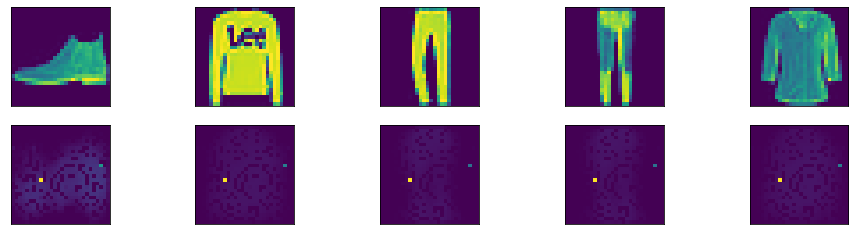

In [ ]:
#Con relu y SGD no ejecutar
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder4.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

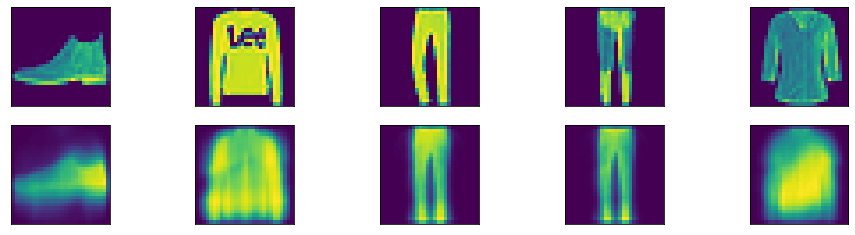

In [25]:
#Con sigmoid y adam
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(autoencoder4.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

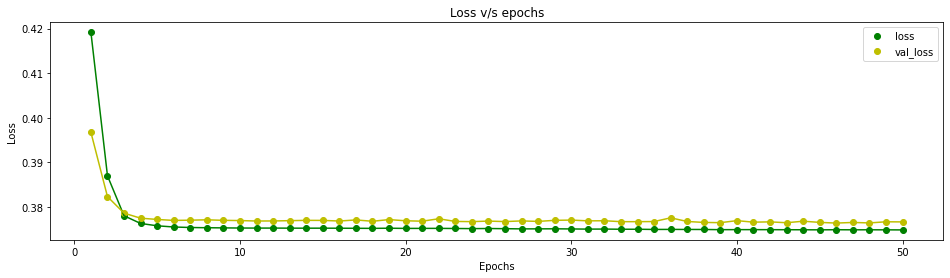

In [24]:
import matplotlib.pyplot as plt
hist5.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist5.history['loss']
hist5.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist5.history['loss'], 'go', label='loss')
plt.plot(r, hist5.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist5.history['loss'], 'g')
plt.plot(r, hist5.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Observacion:** A medida que va disminuyendo la dimension de la capa oculta la resolucion de la imagen empeora. Empeora mas cuando es representada por un 25% de su tamaño original. La perdida tambien aumenta a medida que se disminuye la dimension de la capa oculta. Los valores de perdida en los conjuntos de entrenamiento y en el conjunto de validacion son muy similares para todas las dimensiones. 
Cuando el tamaño es dos todos los objetos por lo menos los del ejemplo los trata como casi que iguales a todos, identifica solo el abrigo en ese estado, cuando se usa Adam como optimizador mejora la calidad de la imagen. En el 50% se visualiza como una persona con miopia ve las cosas no es muy buena la reconstruccion. Se reduce la perdida de 0.45 a alrededor de 0.25 cuando se utiliza el optimizador Adam en vez de SGD. 

## 3.e) Deep autoencoder

Pruebe ahora con una arquitectura ligeramente más profunda. Para esto utilice a lo menos 3 capas de encoding, es decir, 3 capas que progresivamente reduzcan la dimensionalidad de la representación hasta una dimensión objetivo inicialmente igual a la mejor obtenida en la pregunta anterior. Utilice igualmente a lo menos 2 capas de decoding, que se encarguen de aumentar la dimensionaliad de la representación hasta alcanzar la dimensión de la imagen original. Note que las primeras capas no necesariamente deben tener menor dimensionalidad que la imagen, la dimensión relevante es aquella de la última capa de encoding. 

Una vez esté satisfecho con su arquitectura profunda, varíe la dimensión objetivo de la última capa de encoding, realizando una exploración similar a la pregunta anterior. Utilice gráficos y muestre algunas imágenes reconstruidas para complementar sus comentarios. 

**Preguntas:**

i) ¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

ii) ¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas?

i)Aumentando el numero de capas y filtros. Si el numero de capas escondidas debe de mejorar la representacion comprimida. El aumento de parametros esta relacionado a la cantidad de capas y de cosas que se le coloque a la red por lo que de muchas formas se puede aumentar los parametros entrenables. Otras opciones para es aumentar mas capas que reduzcan progresivamente el tamaño porque actualmente es de 784 a 128 en esa parte hay perdida de informacion en la representacion comprimida. 

ii)Si es posible para otros dataset como el mnist que solo es de numeros. Pero para el caso de este dataset y para el uso de capas densas se tiene menor perdida usando ciertos valores de dimensionalidad.

In [26]:
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential

dautoencoder = Sequential()
dautoencoder.add(Dense(128,activation='relu'))
dautoencoder.add(Dense(64,activation='relu'))
dautoencoder.add(Dense(32,activation='relu')) # encoder

dautoencoder.add(Dense(64,activation= 'relu'))
dautoencoder.add(Dense(128,activation= 'relu')) 
dautoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

dautoencoder.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
hist6 = dautoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))


Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3447 - val_loss: 0.2961
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2914 - val_loss: 0.2888
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2864 - val_loss: 0.2858
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2832 - val_loss: 0.2831
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2807 - val_loss: 0.2830
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2798 - val_loss: 0.2818
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2791 - val_loss: 0.2810
Epoch 8/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2778 - val_loss: 0.2801
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2774 - val_loss: 0.2799
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.277

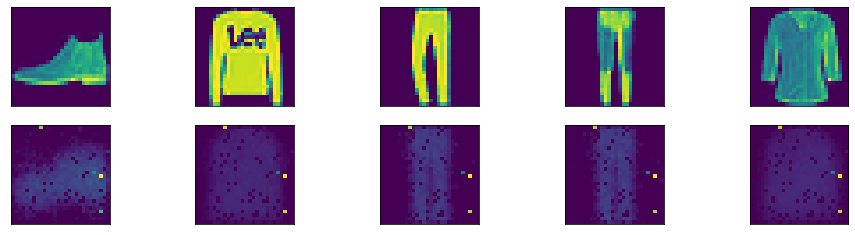

In [ ]:
#con relu
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(dautoencoder.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

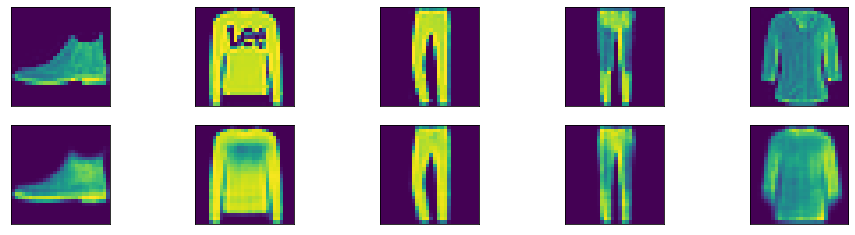

In [27]:
#con sigmoid y Adam
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_vector_scaled[v].reshape(28,28))
    else:
      plt.imshow(dautoencoder.predict(x_val_vector_scaled)[v].reshape(28,28))
    ix += 1
plt.show()

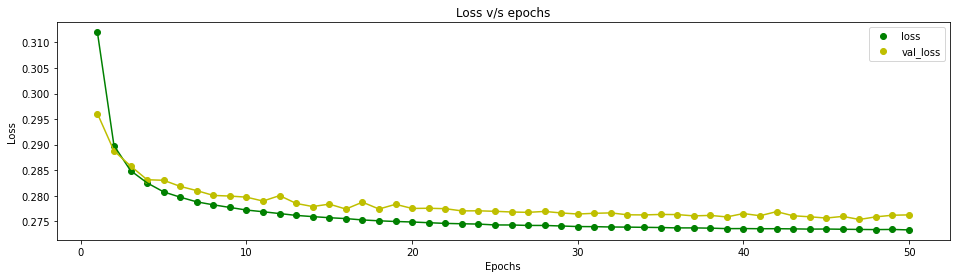

In [28]:
import matplotlib.pyplot as plt
hist6.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist6.history['loss']
hist6.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist6.history['loss'], 'go', label='loss')
plt.plot(r, hist6.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist6.history['loss'], 'g')
plt.plot(r, hist6.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Comentarios:** Se puede ver que existe un cambio cuando se le pone de funcion de activacion relu a cuando se utiliza sigmoide en la capa final. Los resultados de perdida son mejores que en las arquitecturas  anteriores. Mezclando las dos tecnicas de reducir dimensionalidad pero progresivamente y aumentando el numero de capas de acuerdo al tamaño de la entrada seria algo que podria mejorar la representacion comprimida. Disminuye los valores de perdida usando el optimizador Adam en vez de SGD.  

## 3.f) Convolutional Autoencoder

Como hemos hasta ahora  utilizado una arquitectura fully connected, nuestra red no toma en cuenta la infomación local contenida en la proximidad de un pixel en la imagen. Como vimos en la tarea anterior, esta información podría ser crucial al momento de procesar imágenes. 

En este item deberá implementar un autoencoder convolucional. La sección de encoding de la red se creará de igual manera que las redes convolucionales creadas en la tarea 1. Puede utilizar capas de Max Pooling o Strides mayores a 1 para reducir la dimensionalidad en esta etapa. Tenga en mente como varía la dimensión de la imagen a lo largo del proceso. 

Para luego recuperar la dimensionalidad de la imagen original debemos utilizar una capa llamada usualmente como "Deconvolution Layer". Esta capa realiza el proceso inverso que aquel realizado por una capa convolucional, por lo cual utilizando por ejemplo `stride=2` puede duplicar la dimensionalidad de su input. 

Puede realizar la profundidad que desee, pero tome en cuenta que una mayor profundidad de la sección convolucional permite a la red reducir dimensionalidad más lentamente, sin "forzar" la compresión de las características. Note que para reconstruir la dimensión original puede usar `output_padding` para corregir problemas de paridad, entre otros. 

Puede igualmente optar por usar algun número de capas densas en el cuello de botella del autoencoder, usando al comienzo de esta una capa `Flatten` y al final de ella una capa `Reshape` (`keras.layers.Reshape(target_shape)`) para recuperar la bidimensionalidad.

¡No olvide que para entrenar esta red debe usar la versión bidimensional de los datos escalados!

Visualice que tan bien se comporta la convolución, en terminos de la función de pérdida y visualizando las imagenes reconstruidas. Compárese con la red densa. 

In [29]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential
conv=Sequential()
#E
conv.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
conv.add(MaxPooling2D(pool_size=(2,2), padding='same'))
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))#le quite el input_shape porque ese lo coge de la capa anterior
conv.add(MaxPooling2D(pool_size=(2,2), padding='same'))
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))#le quite el input_shape porque ese lo coge de la capa anterior
conv.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#D
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

conv.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')
conv.summary()
x_train = np.reshape(x_train_vector_scaled, (len(x_train_vector_scaled), 28, 28, 1))
x_test = np.reshape(x_val_vector_scaled, (len(x_val_vector_scaled), 28, 28, 1))
hist7 = conv.fit(x_train,x_train,epochs=50,validation_data=(x_test,x_test))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)          

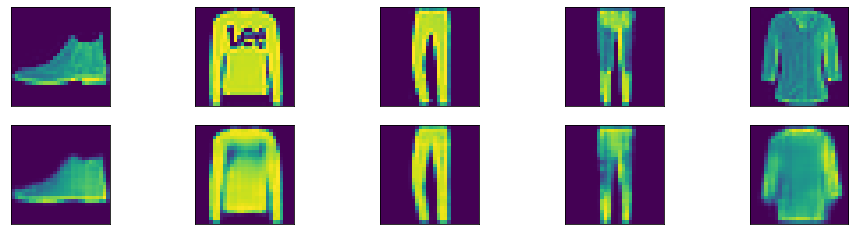

In [30]:
#con Adam
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_test[v].reshape(28,28))
    else:
      plt.imshow(conv.predict(x_test)[v].reshape(28,28))
    ix += 1
plt.show()

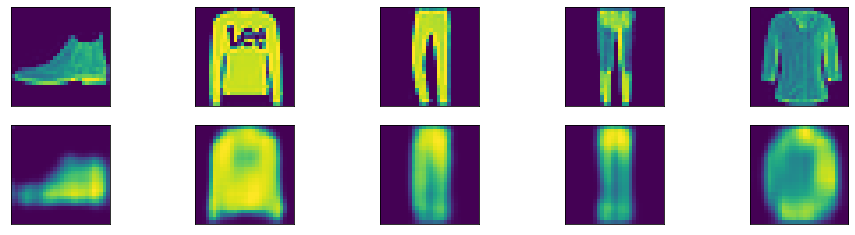

In [ ]:
#con SGD
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_test[v].reshape(28,28))
    else:
      plt.imshow(conv.predict(x_test)[v].reshape(28,28))
    ix += 1
plt.show()

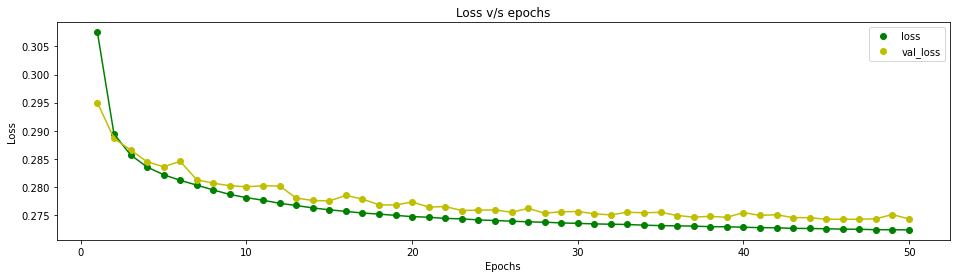

In [31]:
import matplotlib.pyplot as plt
hist7.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist7.history['loss']
hist7.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist7.history['loss'], 'go', label='loss')
plt.plot(r, hist7.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist7.history['loss'], 'g')
plt.plot(r, hist7.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Comentarios:** Cuando el optimizador es SGD mejora la perdida disminuyendo aproximadamente 10 puntos con respecto a la arquitectura anterior(deep autoencoder), cuando es Adam casi no hay cambio entre la deep y la convolucional. La representacion grafica de la arquitectura anterior teniendo mas perdida tiene mas detalles en los ejemplos escogidos que la arquitectura convolucional. En este caso se sospecha que agregando mas capas que reduzcan progresivamente la dimensionalidad mejore la compresion porque en este caso se escogio strides de 3. Tal vez con uno de 2 se pueda representar mejor los detalles que es algo que se busca al realizar este tipo de codificaciones.  

## 3.g) Denoising Autoencoder 

Otra utilidad que se le ha dado a los autoencoders es la posibilidad de utilizarlos para separar ruido de información. Para entrenar tal tipo de modelo, la idea es simple: utilizar como datos de entrada imagenes a las cuales se les ha agregado artificialmente ruido y como objetivo la imagen original sin ruido. 

Entrene alguna arquitectura de autoencoder que le parezca apropiada para la tarea utilizando algún tipo de ruido aleatorio. Puede utilizar cambios en valores de pixeles aleatoriamente, o por ejemplo "promediar" ponderadamente la imagen original con alguna otra imagen del dataset ligeramente modificada. Puede utilizar las librerías `random` de `numpy`. Sea creativo, puede crear el ruido que desee. Idealmente, considerando la naturaleza del problema que se buscaría modelar (eliminar ruido real de mediciones), la naturaleza del ruido agregado debe ser estocástica y no puede "repetirse" el mismo patrón de ruido a lo largo de todo el entrenamiendo, es decir, si agregó un ruido estocástico a cada imágen del conjunto, este proceso debe iterarse igualmente luego de cada época de entrenamiento, para evitar que la red aprenda un patrón especifico de ruido, si no aprenda realmente a diferenciar ruido sin información de la información suyaciente a la imagen. 

Una vez esté satisfecho con la red, muestre ejemplos de la imagen con ruido, la imagen original y la imagen reconstruida. Pruebe igualmente entregarle a la red nuevas.

In [32]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.optimizers import SGD
from keras.models import Sequential

#Encoder
autoencodern = Sequential()
autoencodern.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
autoencodern.add(MaxPooling2D(pool_size=(2,2), padding='same'))
autoencodern.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))#le quite el input_shape porque ese lo coge de la capa anterior
autoencodern.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#Decoder
autoencodern.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
autoencodern.add(UpSampling2D((2, 2)))
autoencodern.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
autoencodern.add(UpSampling2D((2, 2)))
autoencodern.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencodern.summary()
#autoencodern.compile(optimizer='adam', loss='binary_crossentropy')
autoencodern.compile(optimizer=Adam(lr=0.002),loss='binary_crossentropy')


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)       

In [33]:
x_train = np.reshape(x_train_vector_scaled, (len(x_train_vector_scaled), 28, 28, 1))
x_test = np.reshape(x_val_vector_scaled, (len(x_val_vector_scaled), 28, 28, 1))
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_tr_noise = np.clip(x_train_noisy, 0., 1.)
x_val_noise = np.clip(x_test_noisy, 0., 1.)

In [34]:
print(len(x_tr_noise),len(x_train),len(x_val_noise),len(x_test))

60000 60000 10000 10000


In [35]:
hist8 = autoencodern.fit(x_tr_noise,x_train,epochs=50,validation_data=(x_val_noise,x_test))
#hist8 = conv.fit(x_tr_noise,x_tr,epochs=50,validation_data=(x_val_noise,x_val))

Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3332 - val_loss: 0.3023
Epoch 2/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2983 - val_loss: 0.2977
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2947 - val_loss: 0.2952
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2925 - val_loss: 0.2948
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2914 - val_loss: 0.2940
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2916 - val_loss: 0.2934
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2903 - val_loss: 0.2929
Epoch 8/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2911 - val_loss: 0.2929
Epoch 9/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2910 - val_loss: 0.2935
Epoch 10/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.290

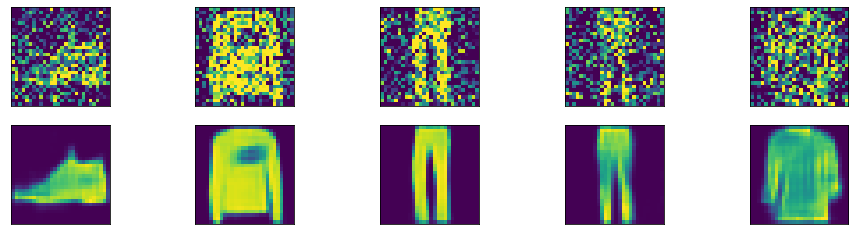

In [36]:
#con Adam
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_noise[v].reshape(28,28))
    else:
      plt.imshow(autoencodern.predict(x_val_noise)[v].reshape(28,28))
    ix += 1
plt.show()

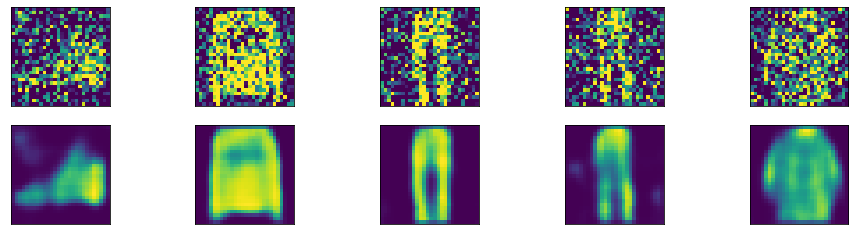

In [ ]:
#con SGD
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(2):
  for v in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_val_noise[v].reshape(28,28))
    else:
      plt.imshow(autoencodern.predict(x_val_noise)[v].reshape(28,28))
    ix += 1
plt.show()

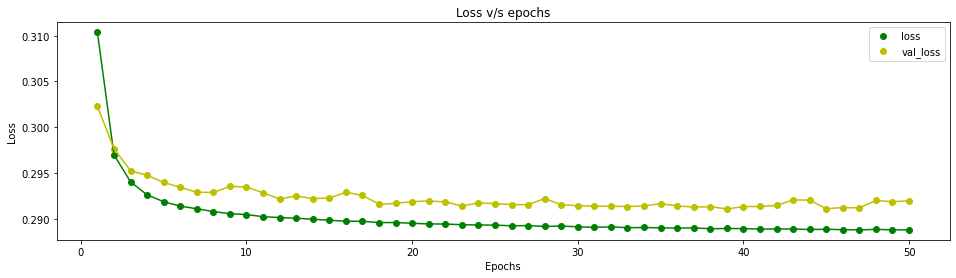

In [37]:
import matplotlib.pyplot as plt
hist8.history
#hist.history['accuracy']
#hist.history['val_accuracy']
hist8.history['loss']
hist8.history['val_loss']
r = range(1,51,1)
#plt.plot(r, hist.history['accuracy'], 'ro', label='accuracy')
#plt.plot(r, hist.history['val_accuracy'], 'bo', label='val_accuracy')
plt.title('Loss v/s epochs')
plt.plot(r, hist8.history['loss'], 'go', label='loss')
plt.plot(r, hist8.history['val_loss'], 'yo', label='val_loss')
#plt.plot(r, hist.history['accuracy'], 'r')
#plt.plot(r, hist.history['val_accuracy'], 'b')
plt.plot(r, hist8.history['loss'], 'g')
plt.plot(r, hist8.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Comentarios:** El ruido ingresado es aleatorio y es al 50%. La prediccion esta dentro de los rangos que muestra el uso de capas convolucionales. Aparte de eso elimina el ruido. Se podria probar los resultados de esto en imagenes con mensajes escondidos como en esteganografia.  

## 3.h) Generación de imágenes

Otra utilización posible que podría darse, quizás, a los autoencoders, es utilizar los decoders para generar nuevas imágenes. La idea de esto sería considerar que la habilidad que tiene la sección decoder de generar una imágen a partir de una representación de menor dimensionalidad puede aprovecharse. 

Para esto, extraiga la sección de encoding y la sección de decoding de alguno de los autoencoders entrenados que prefiera. Obtenga los valores de la representación interna de las imágenes usando el encoder para calcularlos. Luego agréguele a esta representación algún ruido de su preferencia, y calcule la imágen resultante utilizando el decoder. ¿Qué observa? Muestre las imágenes obtenidas junto con otras imágenes de la misma categoría que la imágen que utilizó originalmente. Pruebe con distintos valores de ruido.

Pruebe también, por ejemplo, calcular la imágen obtenida al promediar las representaciones comprimidas de varias (o todas) las imágenes de una clase. Utilice el encoder para generar imágenes a partir de otros valores que se les ocurran y especule sobre el por qué la imágen obtenida se asimila o no a las imágenes del dataset. 

In [38]:
import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.optimizers import SGD
from keras.models import Sequential

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)
encoder = keras.Model(input_img, encoded)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
decoder_input = keras.Input(shape=(encoded.shape[1:4]))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = keras.Model(decoder_input, decoded)


auto_input = keras.Input(shape=(28,28,1))
encoded = encoder(auto_input)
decoded = decoder(encoded)

autoencoderg = keras.Model(auto_input, decoded)

encoder.summary()
decoder.summary()
autoencoderg.summary()

autoencoderg.compile(optimizer=Adam(lr=0.002), loss='binary_crossentropy')
hist7 = autoencoderg.fit(x_train,x_train,epochs=50,validation_data=(x_test,x_test))

(None, 4, 4, 8)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 8) 

In [39]:
#encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

noise_factor = 0.9
encoded_imgs_noisy9 = encoded_imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=encoded_imgs.shape) 
noise_factor = 0.75
encoded_imgs_noisy75 = encoded_imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=encoded_imgs.shape)
noise_factor = 0.5
encoded_imgs_noisy5 = encoded_imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=encoded_imgs.shape)
noise_factor = 0.25
encoded_imgs_noisy25 = encoded_imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=encoded_imgs.shape)

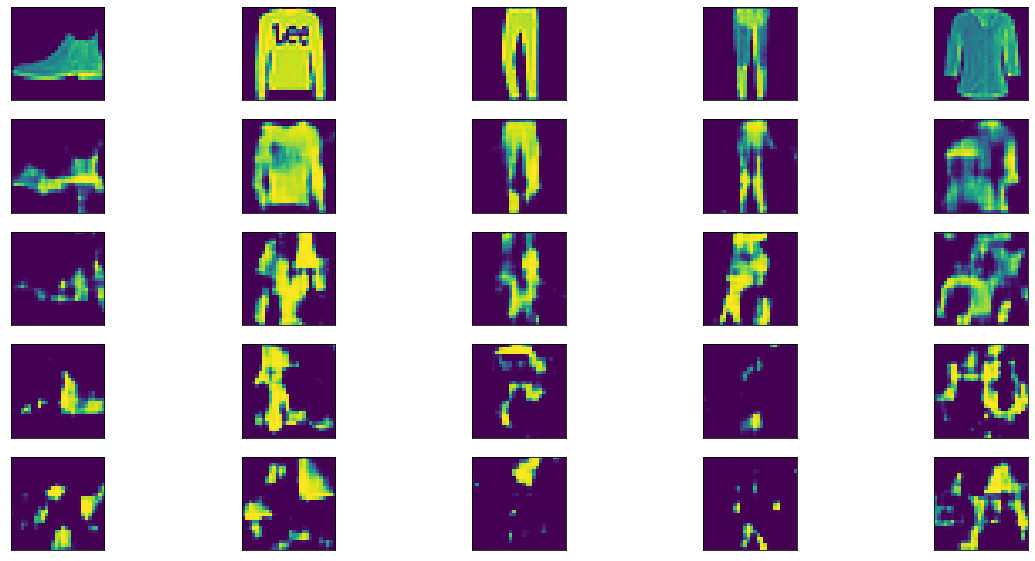

In [40]:
plt.rcParams["figure.figsize"]=[20,10]
ix = 1
for u in range(5):
  for v in range(5):
    ax = plt.subplot(5,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if u == 0:
      plt.imshow(x_test[v].reshape(28,28))
    elif u == 1:
      plt.imshow(decoder.predict(encoded_imgs_noisy25)[v].reshape(28,28))
    elif u == 2:
      plt.imshow(decoder.predict(encoded_imgs_noisy5)[v].reshape(28,28))
    elif u == 3:
      plt.imshow(decoder.predict(encoded_imgs_noisy75)[v].reshape(28,28))
    elif u == 4:
      plt.imshow(decoder.predict(encoded_imgs_noisy9)[v].reshape(28,28))
    ix += 1
plt.show()

Se inserto ruido aleatorio de 90, 75, 50 y 25 %, el orden en el que se inserta el ruido de menor a mayor en la capa codificada, se va perdiendo la imagen original, se crean nuevas imagenes que no se asemejan a la original.
Su uso se muestra mejor en esta imagen que es una forma de generar los conocidos deep fakes.

<img src="https://stackabuse.s3.amazonaws.com/media/image-reconstruction-and-denoising-with-autoencoders-in-python-and-keras-20.png" alt="face swap">